In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [52]:
data = pd.read_csv('csvs/sim_verify_acc=1_yaw_incl_2020-06-04-19-18-09/_slash_ground_truth_slash_car_info.csv')

# Remove empty columns
data = data.dropna(axis=1)

# Make the index to be the timestamp
data.index = pd.to_datetime(data.rosbagTimestamp.values)

dt = data.dt.mean()

# Remove not interesting/redundant columns
data = data.drop(["dt", "seq", "secs", "nsecs", "frame_id", "rosbagTimestamp", "front_slip_angle", "rear_slip_angle", "next_v_x", "next_v_y", "next_r", "next_yaw"], axis=1)

data.head()

,delta,acc,current_v_x,current_v_y,current_r,current_yaw
1970-01-01 00:00:42.867,0.0,-0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:42.867,0.0,-0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:42.867,0.0,-0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:42.867,0.0,-0.0,0.0,0.0,0.0,0.0
1970-01-01 00:00:42.867,0.0,-0.0,0.0,0.0,0.0,0.0


In [53]:
# Add slip angle
data["slip"] = -np.arctan2(data.current_v_y, np.abs(data.current_v_x))

In [56]:
# Calculate linear derivatives
data['v_x_dot'] = np.hstack(((data.current_v_x.values[1:] - data.current_v_x.values[:-1])*(1/dt), np.nan))
data['v_y_dot'] = np.hstack(((data.current_v_y.values[1:] - data.current_v_y.values[:-1])*(1/dt), np.nan))
data['r_dot'] = np.hstack(((data.current_r.values[1:] - data.current_r.values[:-1])*(1/dt), np.nan))
data = data.dropna()
# data.tail()

In [41]:
# investigate data filtering
len_data = len(data)
print(len(data), "raw data entries")
print(len(data[data.current_v_x < 1])/len_data, "% of data entries with <1 v_x")
print(len(data[np.abs(data.slip) > 0.75])/len_data, "% of data entries with <0.75 slip")

344280 raw data entries
0.019899500406645752 % of data entries with <1 v_x
0.002114557917973742 % of data entries with <0.75 slip


In [48]:
# Filter bad data
data = data[np.abs(data.slip) < 0.75]
data = data[data.current_v_x > 1.0]

# Filter outlier data from v_y_dot and r_dot axis
q0 = data.v_y_dot.quantile(0.025)
q1 = data.v_y_dot.quantile(0.975)

data = data[q0 < data.v_y_dot]
data = data[data.v_y_dot < q1]

len(data)

320557

In [49]:
renames = {"current_v_x": "v_x",
          "current_v_y": "v_y",
          "current_r": "r",
          "current_yaw": "yaw",
          "delta": "delta_cmd",
          "acc": "acc_cmd"}
data = data.rename(renames, axis=1)

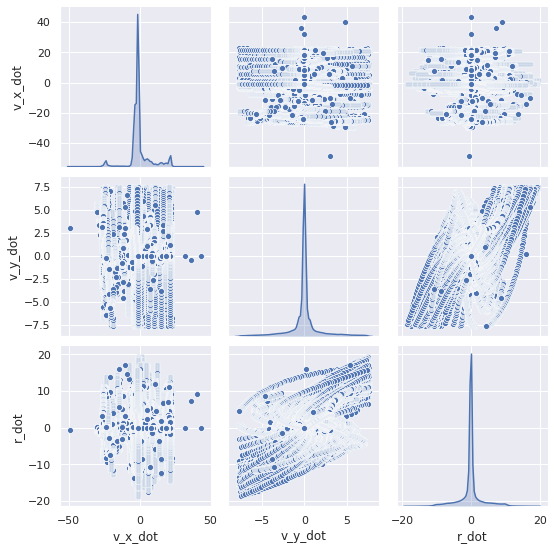

In [50]:
sns.pairplot(data[['v_x_dot', 'v_y_dot', 'r_dot']], diag_kind="kde")